# Summary of the project


### 1. Import Data
### 2. Dealing with Missing Data
### 3. Prepare Data for One-Hot-Encoding
### 4. Built a Preliminary Tree
### 5. Prune the Tree and use Cross-Validation
### 6. Final Tree and considerations

# Imports

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import plot_tree # To draw the classification tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.model_selection import cross_val_score #For cross validation
from sklearn.metrics import confusion_matrix #To create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # To draw the confusion matrix

## Import the dataset

In [2]:
df = pd.read_csv('../Data/loan_data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [3]:
df.shape

(381, 13)

In [4]:
df.drop(labels='Loan_ID', axis = 1, inplace = True)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


# Preprocessing the data

## Part 1: Identifying missing data

In [5]:
df.isna().sum()

Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
nulls = df.isna()

g = nulls.Gender
d = nulls.Dependents
s = nulls.Self_Employed
l = nulls.Loan_Amount_Term
c = nulls.Credit_History

null_list = []

for i in range(0,381):
    if (g[i] or d[i] or s[i] or l[i] or c[i]):
        null_list.append(i)

In [7]:
nulls = df.iloc[null_list,:]
nulls

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
6,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
10,Male,No,1,Not Graduate,No,3596,0.0,100.0,240.0,NaN,Urban,Y
13,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
16,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
20,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,1.0,Semiurban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
354,Male,Yes,0,Not Graduate,No,4467,0.0,120.0,360.0,NaN,Rural,Y
361,NaN,Yes,0,Graduate,No,3087,2210.0,136.0,360.0,0.0,Semiurban,N
366,Male,Yes,1,Graduate,No,1880,0.0,61.0,360.0,NaN,Rural,N
370,NaN,No,0,Graduate,No,4750,0.0,94.0,360.0,1.0,Semiurban,Y


In [8]:
round(nulls.shape[0]/df.shape[0], 3)*100

19.2

We have approximately 19% of inputs with at least one missing value. Therefore, because it is a big percentage of the data, it do not seems a good idea drop the inputs with missing values.

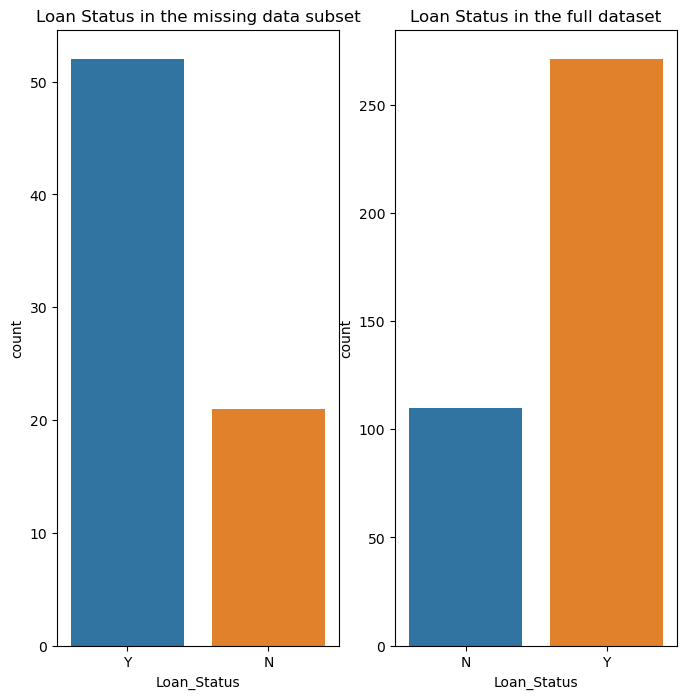

In [9]:
fig, axes = plt.subplots(ncols= 2, figsize=(8,8))


sns.countplot(data = nulls, x = 'Loan_Status', ax = axes[0])
sns.countplot(data= df, x = 'Loan_Status', ax = axes[1])

axes[0].set_title('Loan Status in the missing data subset')
axes[1].set_title('Loan Status in the full dataset')

plt.show()

The data that have missing values seems to have the same proportion of loan status as the full dataset. Therefore, the missing data seems not be biased.

## Part 2: Train and test split

First we should do the split in the dataset, then do the data imputation avoiding unbalanced inputs.

In [10]:
X = df.drop('Loan_Status', axis = 1).copy()
X.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban


In [11]:
y = df.Loan_Status.copy()
y.head(3)

0    N
1    Y
2    Y
Name: Loan_Status, dtype: object

### The split itself

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Part 3: Dealing with the of missing values

For that we gonna procede the following way: put the mode value in each missing category.

**Imputation in the train dataset**

In [13]:
missing_values_list = ['Gender', 'Dependents', 'Self_Employed', 'Credit_History']

for feature in missing_values_list:
    print(X_train[feature].value_counts())

Gender
Male      222
Female     61
Name: count, dtype: int64
Dependents
0     172
2      45
1      41
3+     21
Name: count, dtype: int64
Self_Employed
No     247
Yes     23
Name: count, dtype: int64
Credit_History
1.0    217
0.0     45
Name: count, dtype: int64


Since Gender have more men than women, we gonna fill the missing values with 'Male'.

In [14]:
X_train.Gender.fillna(value = 'Male', inplace = True)
X_train.Gender.isna().sum()

0

Since Dependents have 0 as the most commun value, we gonna fill the missing values with 0.

In [15]:
X_train.Dependents.fillna(value = 0, inplace = True)
X_train.Dependents.isna().sum()

0

Since Self_Employed have more 'No' than 'Yes' , we gonna fill the missing values with 'No'.

In [16]:
X_train.Self_Employed.fillna(value = 'No', inplace = True)
X_train.Self_Employed.isna().sum()

0

Since the marjority of the clients have Credit_History = 1.0, we gonna fill the missing values with 1.0

In [17]:
X_train.Credit_History.fillna(value = 1.0, inplace = True)
X_train.Credit_History.isna().sum()

0

Now, we should also take care of the missing values that are numerical. There are missing values in Loan_Amount_Term

In [18]:
mode = X_train.Loan_Amount_Term.mode()[0]

X_train.Loan_Amount_Term.fillna(value = mode, inplace = True)

X_train.Loan_Amount_Term.isna().sum()

0

**Imputation in the test dataset**

In [19]:
for feature in missing_values_list:
    print(X_test[feature].value_counts())

Gender
Male      69
Female    24
Name: count, dtype: int64
Dependents
0     62
2     14
1     11
3+     7
Name: count, dtype: int64
Self_Employed
No     78
Yes    12
Name: count, dtype: int64
Credit_History
1.0    77
0.0    12
Name: count, dtype: int64


The proportions in the test dataset seems to be very close to the proportions in the train dataset. Therefore, we gonna procede in the same way for the test dataset.

In [20]:
X_test.Gender.fillna(value = 'Male', inplace = True)
X_test.Gender.isna().sum()

0

In [21]:
X_test.Dependents.fillna(value = 0, inplace = True)
X_test.Dependents.isna().sum()

0

In [22]:
X_test.Self_Employed.fillna(value = 'No', inplace = True)
X_test.Self_Employed.isna().sum()

0

In [23]:
X_test.Credit_History.fillna(value = 1.0, inplace = True)
X_test.Credit_History.isna().sum()

0

In [24]:
mode = X_test.Loan_Amount_Term.mode()[0]

X_test.Loan_Amount_Term.fillna(value = mode, inplace = True)

X_test.Loan_Amount_Term.isna().sum()

0

## Part 4: One-Hot Encoding

Now, we should notice that are some categorical features in our dataset and the [scikitlearn decision tree does not support categorical data](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart). Thus, we gonna need to do one-hot encoding.

For that, let's use pd.get_dummies() function.

In [25]:
pd.get_dummies(df, columns = ['Gender'], dtype = int)

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Gender_Female,Gender_Male
0,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0,1
1,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0,1
2,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0,1
3,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0,1
4,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Yes,3+,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y,0,1
377,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,0,1
378,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,1,0
379,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,0,1


In [26]:
df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [27]:
categorical_data = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

X_train_encoded = pd.get_dummies(X_train, columns = categorical_data, dtype = int)

X_train_encoded.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
337,2550,2042.0,126.0,360.0,0,1,1,0,0,1,...,0,0,1,1,0,0,1,1,0,0
331,5677,1424.0,100.0,360.0,0,1,0,1,0,0,...,1,1,0,0,1,0,1,1,0,0
297,6000,0.0,140.0,360.0,0,1,1,0,0,1,...,0,1,0,1,0,0,1,1,0,0
246,2583,2115.0,120.0,360.0,0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,1
126,2479,0.0,59.0,360.0,0,1,1,0,0,1,...,0,1,0,1,0,0,1,0,0,1


In [28]:
X_test_encoded = pd.get_dummies(X_test, columns = categorical_data, dtype = int)

X_test_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
266,5829,0.0,138.0,360.0,0,1,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
192,1625,1803.0,96.0,360.0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1
46,3029,0.0,99.0,360.0,0,1,0,1,0,0,...,1,1,0,1,0,0,1,0,0,1
55,1000,3022.0,110.0,360.0,0,1,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1
57,3846,0.0,111.0,360.0,1,0,1,0,0,1,...,0,1,0,1,0,0,1,0,1,0


In [29]:
y_train_encoded = y_train.map(lambda x: 1 if x == 'Y' else 0)
y_train_encoded.value_counts()

Loan_Status
1    204
0     81
Name: count, dtype: int64

In [30]:
y_test_encoded = y_test.map(lambda x: 1 if x == 'Y' else 0)
y_test_encoded.unique()

array([1, 0], dtype=int64)

# Finally, we are ready to start and build a preliminary tree

In [31]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train_encoded, y_train_encoded)

Let's plot the tree that we just built.

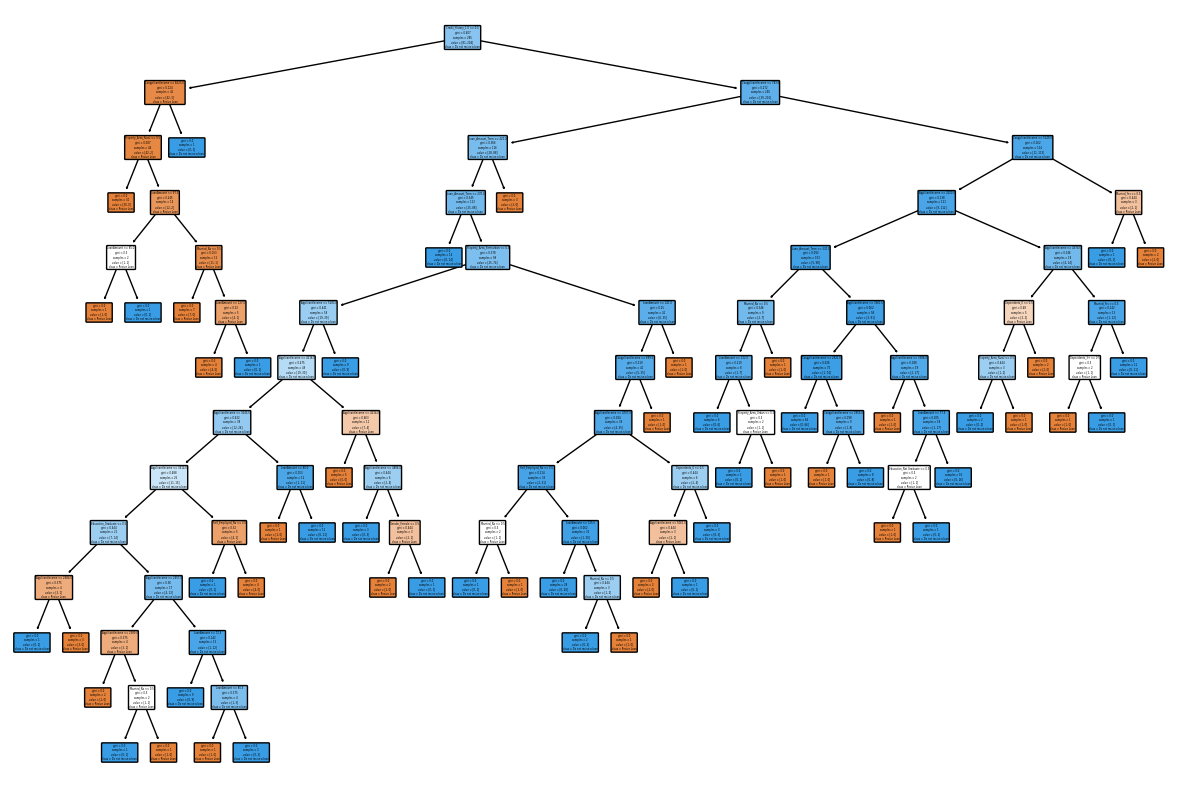

In [32]:
plt.figure(figsize = (15,10))
plot_tree(clf_dt,filled = True, 
          rounded = True, 
          class_names = ['Recive Loan', 'Do not recive a loan'], 
          feature_names = list(X_train_encoded.columns));

In [33]:
predictions = clf_dt.predict(X_test_encoded)

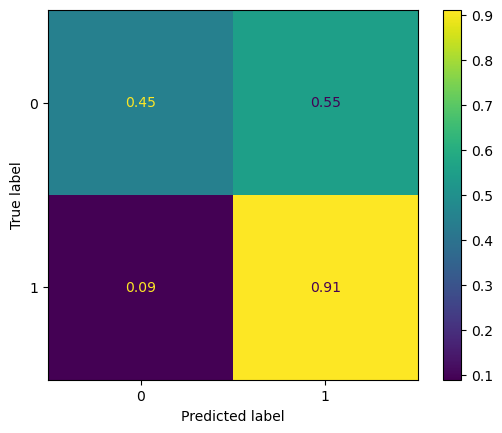

In [39]:
cm = confusion_matrix(y_test_encoded, predictions, labels = clf_dt.classes_, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= list(clf_dt.classes_) )
disp.plot()
plt.show()

**Considerations**

It seems good to predict true labels, but bad(almost the same as flip a coin) in the false labels.

That means we are making good predictions when should concive a loan, but not that good when shouldn't concive a loan.

**Next steps to improve the model**

1. First, we can try to prune the tree.
2. We can try a target encoder in the data set and build a new tree.


**Post-Pruning (Cost Complexity Pruning)**: This involves first allowing the tree to grow fully and then pruning it by removing nodes that have little importance. This is typically done using cost complexity pruning, which is supported in scikit-learn via the ccp_alpha parameter.

In [44]:
path = clf_dt.cost_complexity_pruning_path(X_train_encoded, y_train_encoded)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

In [47]:
clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train_encoded, y_train_encoded)
    clf_dts.append(clf_dt)

In [55]:
train_scores = [clf.score(X_train_encoded, y_train_encoded) for clf in clf_dts]
test_scores = [clf.score(X_test_encoded, y_test_encoded) for clf in clf_dts]

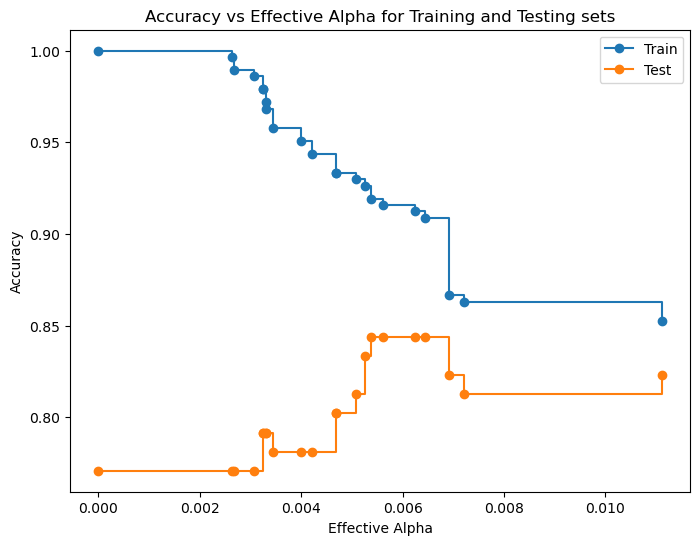

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="Train", drawstyle="steps-post")
plt.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="Test", drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Effective Alpha for Training and Testing sets")
plt.show()

Ok. We can see that the best alpha is little bit less than 0.006.

But, we still can try one more thing. Which is use Cross-Validation to find a even best value of alpha.

We can check the if the value of alpha = 0.005 in different training and test datasets still the optimum value.

<Axes: xlabel='tree'>

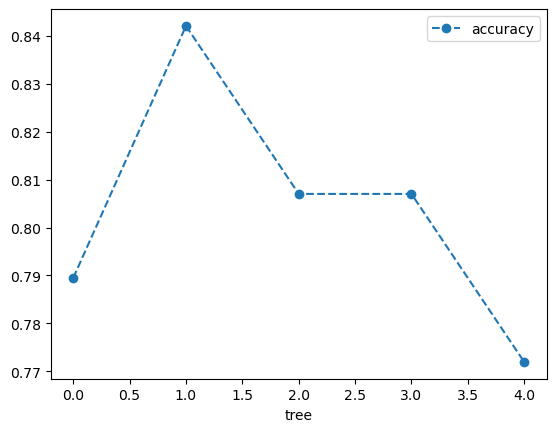

In [59]:
clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = 0.005)

scores = cross_val_score(clf_dt, X_train_encoded, y_train_encoded, cv = 5)

df = pd.DataFrame(data = {'tree':range(5), 'accuracy':scores})

df.plot(x='tree', y='accuracy', marker = 'o', linestyle='--')

As we can see, that value of alpha can make us lose almost 10% points of accuracy

<Axes: xlabel='alpha'>

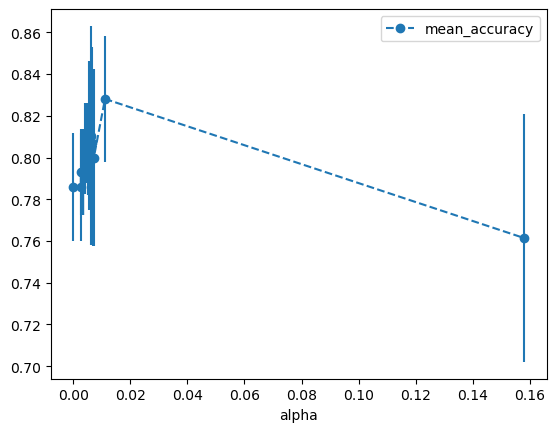

In [61]:
alpha_values_cv = []


for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train_encoded, y_train_encoded, cv = 5)
    alpha_values_cv.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_values_cv, columns = ['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o', linestyle = '--')

Notice that, using cross-validation, alpha = 0.02 is a better value.

We are finally ready for the final tree.

# Final Tree

In [62]:
clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha = 0.02)
clf_dt.fit(X_train_encoded, y_train_encoded)

DecisionTreeClassifier(ccp_alpha=0.02, random_state=42)

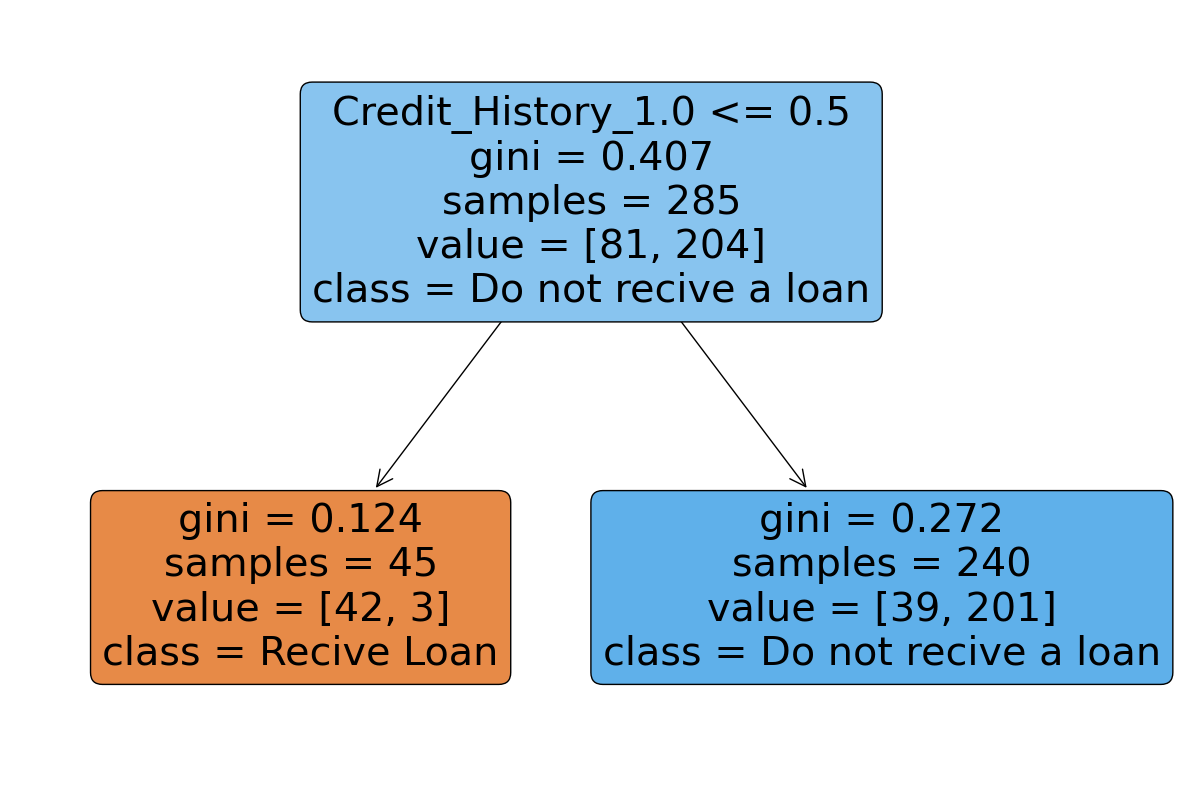

In [63]:
plt.figure(figsize = (15,10))
plot_tree(clf_dt,filled = True, 
          rounded = True, 
          class_names = ['Recive Loan', 'Do not recive a loan'], 
          feature_names = list(X_train_encoded.columns));

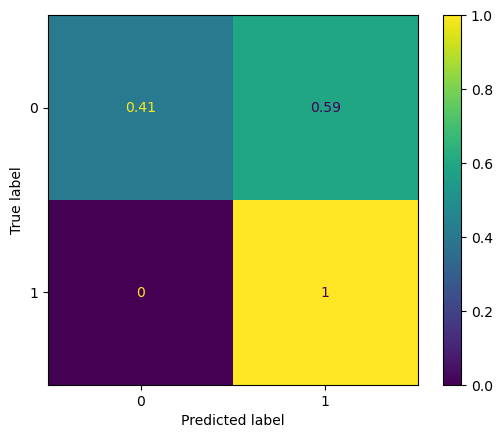

In [64]:
predictions = clf_dt.predict(X_test_encoded)
cm = confusion_matrix(y_test_encoded, predictions, labels = clf_dt.classes_, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= list(clf_dt.classes_) )
disp.plot()
plt.show()

# Final considerations

We achieve a great result predicting true labels! We also got a increase accuracy predicting false labels. Maybe the use of some techniques to balance the dataset should help on get a higher accuracy. That is it! Cya in the next project!